# COMPSCI 371 Homework 3

_**Group Members:**_ Mayur Sekhar, Rithvik Neti, Jai Kasera

### Problem 0 (3 points)

## Part 1: Stochastic Gradient Descent

In [1]:
import urllib.request
import ssl
from os import path as osp
import shutil


def retrieve(file_name, semester='fall24', homework=3):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci371/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [2]:
retrieve('helpers.py', homework=2)

Using previously downloaded file helpers.py


In [3]:
from helpers import Stepper
from autograd import numpy as anp
import numpy as snp


def gradient_descent(
    f, z, alpha, min_step=1.e-6, max_iter=10000, history=False, **kwargs
):
    step = Stepper(f, z, alpha, history=history, **kwargs)
    z, fz, gz = anp.copy(z), step.fz0, step.gz0
    for k in range(max_iter):
        s, z, fz, gz = step(z, **kwargs)
        if anp.linalg.norm(s) < min_step:
            break
    step.show_history()
    return fz, z, k

In [4]:
import pickle


file_name = 'students.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    students = pickle.load(file)

Using previously downloaded file students.pkl


### Problem 1.1

Does the predictor perform well? How can you tell?

Yes, because the predictor has quite low RMS error on the training dataset. Compared to the y values which are around 0.55, the RMS is only 0.035 which means that is predicted fairly well for the training points with minimal loss over all the points.. 

Does it generalize well? How can you tell?

Yes, because the predictor has quite low RMS error on the test dateset. Compared to the train RMS, the test RMS is only 0.0005 greater which means that when the model is used on new data, there is only a marginal increase in RMS. This means that it generalizes well to new data.

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pickle
import urllib.request
import ssl
from os import path as osp
import shutil
import numpy as anp
from helpers import Stepper
import autograd.numpy as anp

anp.random.seed(12)

def rms(ve, x, y):
    bx = ve[0]
    wx = ve[1:]
    pred = bx + np.dot(x, wx)
    res = y - pred
    risk = np.mean(res ** 2)
    avg = np.sqrt(np.mean(y ** 2))
    return np.sqrt(risk) / avg

x_train = students.train.x
y_train = students.train.y
x_test = students.test.x
y_test = students.test.y

regressor = LinearRegression()
regressor.fit(x_train, y_train)

inter = regressor.intercept_ 
cof = regressor.coef_
vec = np.append([inter], cof)
train = rms(vec, x_train, y_train)
X_test = students.test.x
y_test = students.test.y
test = rms(vec, x_test, y_test)

print("Parameters found by training (v):", np.round(vec, 4))
print("Relative RMS error on training set:", np.round(train, 4))
print("Relative RMS error on test set:", np.round(test, 4))

Parameters found by training (v): [0.5523 0.0737 0.1763 0.0082 0.0053]
Relative RMS error on training set: 0.035
Relative RMS error on test set: 0.0355


### Problem 1.2

In [6]:
def risk(v, x=None, y=None, indices=None):
    if indices is None:
        indices = anp.arange(x.shape[0])
    
    xb = x[indices, :]
    yb = y[indices]
    
    b = v[0] 
    w = v[1:] 
    
    predictions = b + anp.dot(xb, w)
    loss = anp.mean((yb - predictions) ** 2)
    
    return loss

In [7]:
btest = 5
wtest = anp.array([1, 2, 3, 4])
vtest = anp.concatenate(([btest], wtest))

x_train = students.train.x
y_train = students.train.y

total_risk = risk(vtest, x=x_train, y=y_train)
print("Risk for entire training set:", np.round(total_risk, 4))

risk_first_100 = risk(vtest, x=x_train, y=y_train, indices=\
                      anp.arange(100))
print("Risk for first 100 samples:", np.round(risk_first_100,4))

risk_last_100 = risk(vtest, x=x_train, y=y_train, indices=\
                     anp.arange(-100, 0))
print("Risk for last 100 samples:", np.round(risk_last_100, 4))


Risk for entire training set: 50.1153
Risk for first 100 samples: 44.3617
Risk for last 100 samples: 53.2272


### Problem 1.3

In [8]:
def sgd(h, v, alpha=1.e-3, x=x_train, y=y_train, batch_size=None,
    min_step=1.e-6, max_epochs=5000, history=True
):
    N = x.shape[0]
    step = Stepper(h, v, alpha, history=history, x=x_train, y=y_train)
    v, fv, gv = anp.copy(v), step.fz0, step.gz0
    
    for epoch in range(max_epochs):
        indices = anp.random.permutation(N)
        
        for i in range(0, N, batch_size or N):
            batch_indices = indices[i:i + (batch_size or N)]
            s, v, fv, gv = step(v, x=x, y=y, indices=batch_indices)
            
            if anp.linalg.norm(s) < min_step:
                step.show_history()
                return fv, v, epoch + 1
        
    step.show_history()
    return fv, v, max_epochs

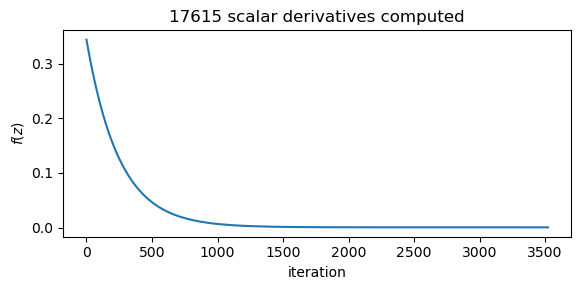

In [9]:
_, v_sgd, totep =  sgd(risk, anp.zeros(len(students.train.x[0]) + 1))
train = rms(v_sgd, x_train, y_train)
x_test = students.test.x
y_test = students.test.y
test = rms(v_sgd, x_test, y_test)


In [10]:

print("Number of Epochs:", np.round(totep, 4))
print("Parameters found by training (v):", np.round(v_sgd, 4))
print("Relative RMS error on training set:", np.round(train, 4))
print("Relative RMS error on test set:", np.round(test, 4))

Number of Epochs: 3522
Parameters found by training (v): [0.5519 0.0736 0.1762 0.0082 0.0054]
Relative RMS error on training set: 0.035
Relative RMS error on test set: 0.0355


### Problem 1.4 (Exam Style)

The algorithms of SGD and regular gradient descent essentially become the same when the batch size is None. The SGD function reduces down to the gradient descent as when the batch size is None, the gradient is calculated on the entire dataset for the loss function for SGD rather tha in the traditional manner of gradient calulations and updates for each small batch. Regular gradient descent calulates the gradient for the whole dataset as well, so they become the same.

### Problem 1.5

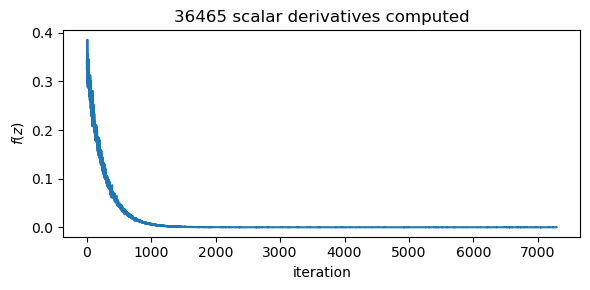

In [11]:
_, v_sgd, totep =  sgd(risk, anp.zeros(len(students.train.x[0]) + 1), \
                       batch_size = 100)
train = rms(v_sgd, x_train, y_train)
x_test = students.test.x
y_test = students.test.y
test = rms(v_sgd, x_test, y_test)


In [12]:

print("Number of Epochs:", np.round(totep, 4))
print("Parameters found by training (v):", np.round(v_sgd, 4))
print("Relative RMS error on training set:", np.round(train, 4))
print("Relative RMS error on test set:", np.round(test, 4))

Number of Epochs: 146
Parameters found by training (v): [0.5523 0.0736 0.1764 0.0082 0.0053]
Relative RMS error on training set: 0.035
Relative RMS error on test set: 0.0355


### Problem 1.6 (Exam Style)

1.3 with batch size as None computed less scalar derivates as it computed 17,615 compared to the 36,465 with the batch size at 100. The ratio of the scalar derivatives of 1.3 to 1.5 is $\frac{17615}{36465} \approx 0.483$ Along with this on the graph, it seems as though there is about 48% as many iterations for 1.3 compared to 1.5 which leads to difference in the computation of scalar derivatives.

### Problem 1.7 (Exam Style)

The reason for the jagged ups and downs in the plot for 1.5 is due to the change in batch size in 1.5 which reflects SGD. 1.3 is more similar to regular gradient descent which leads to the monotonic nature of the function. In 1.3, the reason for this is that the weights of the function are being updated for each of the points which leads to the gradient coming closer to converging. Since it is updated each time, the estimations for th gradient for the next point are more correct which eventually leads to minimizing the loss. On the SGD however, this is done through random batches. As the result, the weights that are used are calculated from the previous batch, and based on variation between the randomized batches, that leads to $q_b > p_b$ in which there is greater loss when the previous weights are allowed to batch $b + 1$. However, the plotting comes down to the fact that $p_b+1$ might be greater than $p_b$ for the loss because it is optimizing the weights for that random batch. This may lead to the minimization of the loss being greater when compared previous iterations of gradient descent. The down comes naturally after then when the batch is more representive of the dataset which would decrease the loss. This fluctuation in order to minimize loss based on the batch optimization leads to the jagged graph.

## Part 2: Linear Score-Based Classifiers

### Problem 2.1 (Exam Style)

To find the decision boundary of the softmax classifier, we need to equate the scores $s_1(x)$ and $s_2(x)$ since the decision boundary is where both classes are equally likely. This happens when the two scores are equal:

$
s_1(x) = s_2(x)
$

Given the score functions:

$
s_1(x) = \log(2 + 3x_1 - x_2)
$
$
s_2(x) = \log(1 - x_1 - 4x_2)
$

### Step 1: Set the scores equal
$
\log(2 + 3x_1 - x_2) = \log(1 - x_1 - 4x_2)
$

### Step 2: Exponentiate both sides to remove the logarithms
$
2 + 3x_1 - x_2 = 1 - x_1 - 4x_2
$

### Step 3: Rearrange the terms
$
(3x_1 + x_1) + (-x_2 + 4x_2) = 1 - 2
$

$
4x_1 + 3x_2 = -1
$

### Step 4: Write the decision boundary in the form $b + w_1x_1 + w_2x_2 = 0$
$
1 + 4x_1 + 3x_2 = 0
$

Thus, the equation of the decision boundary is:

$
1 + 4x_1 + 3x_2 = 0
$

In standard form:

$
b = 1, \quad w_1 = 4, \quad w_2 = 3
$

So the decision boundary equation is:

$
4x_1 + 3x_2 + 1 = 0
$


### Problem 2.2 (Exam Style)

### Decision Boundary from Problem 2.1

From Problem 2.1, we found the decision boundary for the classifier to be:

$
4x_1 + 3x_2 + 1 = 0
$

This can also be expressed in the form $b + w_1 x_1 + w_2 x_2 = 0$ where $b = 1$, $w_1 = 4$, and $w_2 = 3$.

### New Score for $s_1$

Given the new score function for class 1:

$
s'_1(x) = (3 + 4x_1 + 2x_2)^3
$

We need to determine if we can define a new score function $s'_2(x)$ such that the decision boundary remains unchanged.

### Forming $s'_2(x)$

The decision boundary is defined by the condition $s'_1(x) = s'_2(x)$. To maintain the same decision boundary, we want:

$
(3 + 4x_1 + 2x_2)^3 = s'_2(x)
$

This means that $s'_2(x)$ must also equal a function that is equivalent to the original $s_2(x)$ when evaluated at points that satisfy the previous decision boundary.

### Decision Boundary Condition

From the earlier decision boundary condition $4x_1 + 3x_2 + 1 = 0$, we can express $x_2$ in terms of $x_1$:

$
x_2 = \frac{- 1 - 4x_1}{3}
$

Substituting this expression for $x_2$ into the new score $s'_1(x)$:

$
s'_1(x) = \left(3 + 4x_1 + 2 \left(\frac{- 1 - 4x_1}{3}\right)\right)^3
$

This simplifies to:

$
s'_1(x) = \left(3 + 4x_1 + \frac{- 2 - 8x_1}{3}\right)^3
$
$
= \left(\frac{9 + 12x_1 - 2 - 8x_1}{3}\right)^3
$
$
= \left(\frac{7 + 4x_1}{3}\right)^3
$

### Defining $s'_2(x)$

To keep the same decision boundary, we can choose:

$
s'_2(x) = \left(\frac{7 + 4x_1}{3}\right)^3
$

### Conclusion

Yes, it is possible to define a new score $s'_2(x)$ such that the decision boundary remains the same, and one such possible form is:

$
s'_2(x) = \left(\frac{7 + 4x_1}{3}\right)^3
$

This guarantees that the decision boundary will remain at:

$
4x_1 + 3x_2 + 1 = 0
$


### Problem 2.3 (Exam Style)

To find the most ambiguous point $x^* = (x_1^*, x_2^*)$ for the ternary classifier where the classifier $h(x)$ could equally well output labels 1, 2, or 3, we need to determine where the score functions $s_1(x)$, $s_2(x)$, and $s_3(x)$ are equal. 

### Given Score Functions

1. $s_1(x) = \arctan(7 + 3x_1)$
2. $s_2(x) = \arctan(3 + 3x_1 - 2x_2)$
3. $s_3(x) = \arctan(4 + 2x_1)$

### Step 1: Set the Scores Equal

To find the point where the classifier is most ambiguous, we set the score functions equal to each other:

1. Set $s_1 = s_2$:
   $
   \arctan(7 + 3x_1) = \arctan(3 + 3x_1 - 2x_2)
   $
   This leads to:
   $
   7 + 3x_1 = 3 + 3x_1 - 2x_2 \quad \text{(since arctan is monotonic)}
   $

   Simplifying gives:
   $
   2x_2 = -4 \quad \Rightarrow \quad x_2 = -2
   $

2. Set $s_2 = s_3$:
   $
   \arctan(3 + 3x_1 - 2x_2) = \arctan(4 + 2x_1)
   $
   This leads to:
   $
   3 + 3x_1 - 2x_2 = 4 + 2x_1 \quad \Rightarrow \quad 3 + 3x_1 - 2(-2) = 4 + 2x_1
   $

   Substituting $x_2 = -2$ gives:
   $
   3 + 3x_1 + 4 = 4 + 2x_1
   $
   Simplifying yields:
   $
   7 + 3x_1 = 4 + 2x_1
   $
   $
   3x_1 - 2x_1 = 4 - 7 \quad \Rightarrow \quad x_1 = -3
   $

### Step 2: Coordinates of the Most Ambiguous Point

Now we have:
$
x_1^* = -3, \quad x_2^* = -2
$

Thus, the most ambiguous point is:
$
x^* = (-3, -2)
$

### Conclusion

The coordinates of the most ambiguous point $x^*$ where the classifier could equally output labels 1, 2, or 3 are:
$
\boxed{(-3, -2)}
$

### Problem 2.4

In [13]:
import pickle

file_name = 'classifiers.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    classifiers = pickle.load(file)

Using previously downloaded file classifiers.pkl


In [14]:
def pairwise_boundaries(v):
    K = v.shape[0]
    b = {}
    for j in range(K):
        for k in range(j+1, K):
            boundary_vector = v[j] - v[k]
            b[(j, k)] = boundary_vector
    return b


In [15]:
def triple_points(b, K):
    t = {}
    for i in range(K):
        for j in range(i+1, K):
            for k in range(j+1, K):
                b_ij = b[(i, j)]
                b_jk = b[(j, k)]
                b_ik = b[(i, k)]
                
                A = np.array([b_ij[1:], b_jk[1:]])
                B = -np.array([b_ij[0], b_jk[0]])
                
                if np.linalg.det(A) != 0:
                    intersection_point = np.linalg.solve(A, B)
                    t[(i, j, k)] = intersection_point
    return t


In [16]:
import matplotlib.pyplot as plt

def show_lines(b, t, color='red'):
    x0_min, x0_max = plt.xlim()
    x1_min, x1_max = plt.ylim()
    
    for (j, k), boundary in b.items():
        b_jk, w_jk_0, w_jk_1 = boundary
        x_vals = np.linspace(x0_min, x0_max, 400)
        y_vals = -(w_jk_0 * x_vals + b_jk) / w_jk_1  # Solve for x1
        
        plt.plot(x_vals, y_vals, color=color, lw=2)
    
    for point in t.values():
        if x0_min <= point[0] <= x0_max and x1_min <= point[1] <= x1_max:
            plt.scatter(point[0], point[1], color=color, s=70)

    plt.xlim(x0_min, x0_max)
    plt.ylim(x1_min, x1_max)

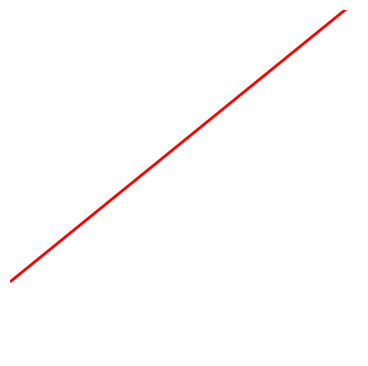

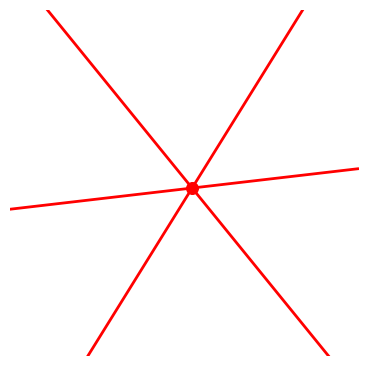

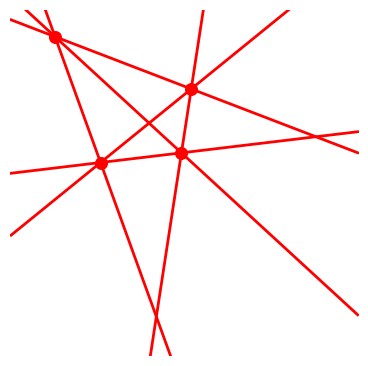

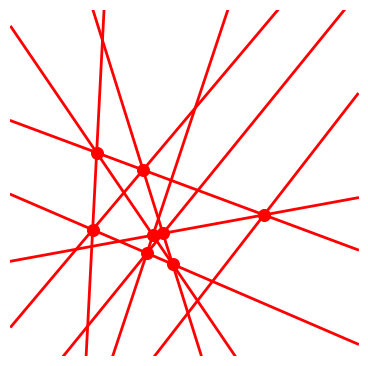

In [17]:
for clf in classifiers:
    v = clf['parameters']
    box = clf['box']
    
    plt.figure(figsize=(4.5, 4.5))
    plt.axis('equal')
    plt.xlim(box[0], box[1])
    plt.ylim(box[2], box[3])
    plt.axis('off')
    
    b = pairwise_boundaries(v)
    K = v.shape[0]
    t = triple_points(b, K)
    
    show_lines(b, t, color='red')
    
    plt.show()

### Problem 2.5

In [18]:
import numpy as np

def decision_regions(v, box, g):
    x0_min, x0_max, x1_min, x1_max = box
    K = v.shape[0]
    
    x0_vals = np.linspace(x0_min, x0_max, g)
    x1_vals = np.linspace(x1_min, x1_max, g)
    grid_x0, grid_x1 = np.meshgrid(x0_vals, x1_vals)
    
    grid_points = np.c_[grid_x0.ravel(), grid_x1.ravel()]
    scores = np.dot(grid_points, v[:, 1:].T) + v[:, 0]
    labels = np.argmax(scores, axis=1)
    
    r = labels.reshape(g, g)
    
    return r


In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def show_regions(r, b, t, box, region_colors, line_color='red'):
    plt.figure(figsize=(4.5, 4.5))
    plt.axis('equal')
    plt.axis('off')
    
    plt.imshow(
        r, aspect=None, origin='upper', extent=box,
        vmin=0, vmax=len(region_colors)-1, alpha=0.5,
        cmap=ListedColormap(region_colors)
    )
    
    show_lines(b, t, color=line_color)
    
    plt.show()

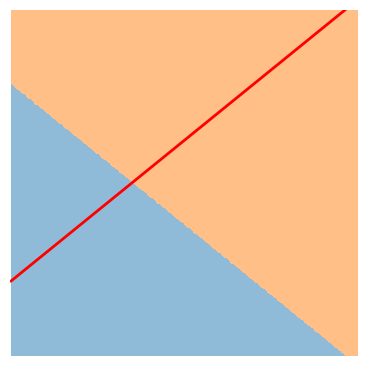

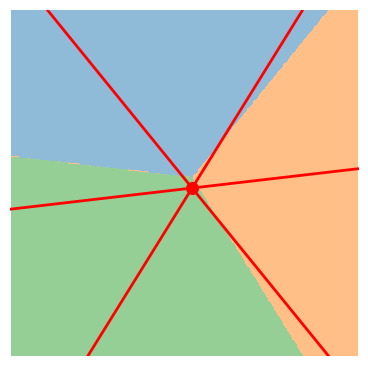

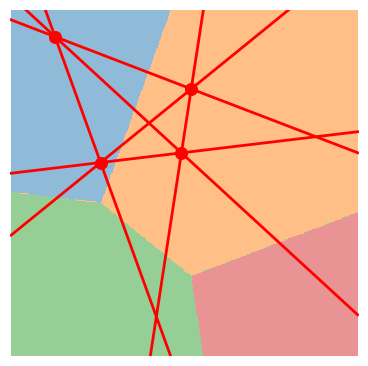

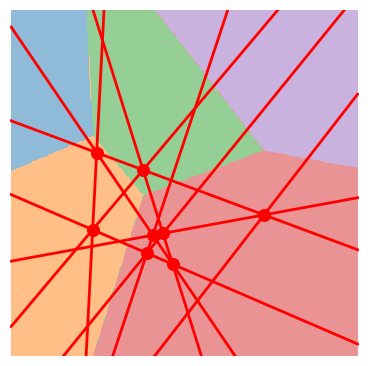

In [20]:
g = 301

for clf in classifiers:
    v = clf['parameters']
    box = clf['box']
    region_colors = clf['colors']
    
    r = decision_regions(v, box, g)
    
    b = pairwise_boundaries(v)
    K = v.shape[0]
    t = triple_points(b, K)
    
    show_regions(r, b, t, box, region_colors, line_color='red')


## Part 3: Linear Classification of Handwritten Digits 

In [21]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from types import SimpleNamespace

digits = datasets.load_digits()
x_train, x_test, y_train, y_test = train_test_split(
    digits.data, digits.target, train_size=900, shuffle=False
)
mnist = SimpleNamespace(
    train=SimpleNamespace(x=x_train, y=y_train),
    test=SimpleNamespace(x=x_test, y=y_test)
)

### Problem 3.1

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(mnist.train.x, mnist.train.y)

train_accuracy = clf.score(mnist.train.x, mnist.train.y)
test_accuracy = clf.score(mnist.test.x, mnist.test.y)

print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

Training accuracy: 1.000
Test accuracy: 0.928


### Problem 3.2 (Exam Style)

1. Each image is 8x8, so the dimension of the data space is $d = 64$.

2. As per the code, you have $900$ training samples, so $N = 900$.

3. There are $10$ classes (digits from $0$ to $9$), so $K = 10$.

4. The number of parameters is $m = d \cdot K = 64 \cdot 10 = 640$ (weights) plus $K = 10$ (biases) giving $m = 650$.

5. The number of pairwise decision boundaries between $K$ classes is $b = \frac{K(K-1)}{2} = \frac{10(10-1)}{2} = 45$.

6. For one iteration of full GD, you need to compute gradients for all parameters, which includes $d \cdot K = 64 \cdot 10 = 640$ weight derivatives and $K = 10$ bias derivatives. The total number of scalar derivatives is $n_{GD} = N \cdot (640+10) = 900 \cdot 650 = 585,000$.

7. The number of scalar derivatives per minibatch is $n_{SGD} = 300 \cdot 650 = 195,000$. One epoch involves $\frac{N}{300}$ minibatches, so the total number of scalar derivatives for one epoch is $n_{SGD} = 3 \cdot 195,000 = 585,000$.